In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import networkx as nx
import urllib
import json
import time
import random
import pickle
import igraph as ig
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
pd.__version__, np.__version__, nx.__version__, ig.__version__

('0.17.1', '1.10.4', '1.11', '0.7.1')

In [2]:
def get_url_friends(uid):
    return 'https://api.vk.com/method/friends.get?user_id=%d' % uid

def get_url_users(uid):
    return 'https://api.vk.com/method/users.get?user_id=%d&fields=city,country,sex,bdate' % uid

In [3]:
def get_friends(uid):
    with urllib.request.urlopen(get_url_friends(uid)) as response:
        data = json.loads(response.read().decode('utf-8')).get('response')
        if data is None:
            print('No friends for', uid, end=', ')
            return []
        return data

def get_users(uid):
    with urllib.request.urlopen(get_url_users(uid)) as response:
        data = json.loads(response.read().decode('utf-8')).get('response')
        if data is None:
            print('No info for', uid, end=', ')
            return []
        return data

In [4]:
my_uid = 12867893
first_run = False

In [5]:
if first_run:
    graph = nx.Graph()
    my_friends = get_friends(my_uid)
    print('adding friends-to-friends relationships from:')
    for friend_uid in my_friends:
        graph.add_edge(my_uid, friend_uid)
        print(friend_uid, end=', ')
        time.sleep(1)
        for deep_friend_uid in get_friends(friend_uid):
            if deep_friend_uid in set(my_friends):
                graph.add_edge(friend_uid, deep_friend_uid)
    nx.write_gpickle(graph, 'graph.pickle')
    print('\ngraph.pickle created')

In [6]:
if first_run:
    users_info = {k:'' for k in graph.nodes()}
    print('Adding info about:')
    for node in users_info.keys():
        print(node, end=', ')
        users_info[node] = get_users(node)
    with open('users_info.pickle', 'wb') as file:
        pickle.dump(users_info, file)

In [7]:
with open('users_info.pickle', 'rb') as file:
    users_info = pickle.load(file)
names = {k: (v[0]['first_name'] + ' ' + v[0]['last_name']) for k,v in users_info.items()}
cities = {k: v[0].get('city', -1) for k,v in users_info.items()}
countries = {k: v[0].get('country', -1) for k,v in users_info.items()}
genders = {k: v[0].get('sex') for k,v in users_info.items()}
bdates = {k: v[0].get('bdate', 'unknown') for k,v in users_info.items()} 

In [8]:
if first_run:
    nx.set_node_attributes(graph, 'gender', genders)
    nx.set_node_attributes(graph, 'city', cities)
    nx.set_node_attributes(graph, 'country', countries)
    nx.set_node_attributes(graph, 'bdate', bdates)
    nx.write_gpickle(graph, 'graph.pickle')

In [9]:
graph = nx.read_gpickle('graph.pickle')
graph.number_of_nodes(), graph.number_of_edges()

(131, 760)

In [10]:
# with open('edgelist.csv', 'w') as file:
#     for a, b, c in nx.to_edgelist(graph):
#         file.write('%s;%s\n' % (a,b))

In [11]:
if first_run:
    pos=nx.spring_layout(graph, k=1.2/np.sqrt(len(nodes)), iterations=1000)
    with open('pos.pickle', 'wb') as file:
        pickle.dump(pos, file)
with open('pos.pickle', 'rb') as file:
    pos = pickle.load(file)
edge_width = 0.6
edge_alpha = 0.15
font_size = 5
linewidths = 0.1
node_alpha = 0.9

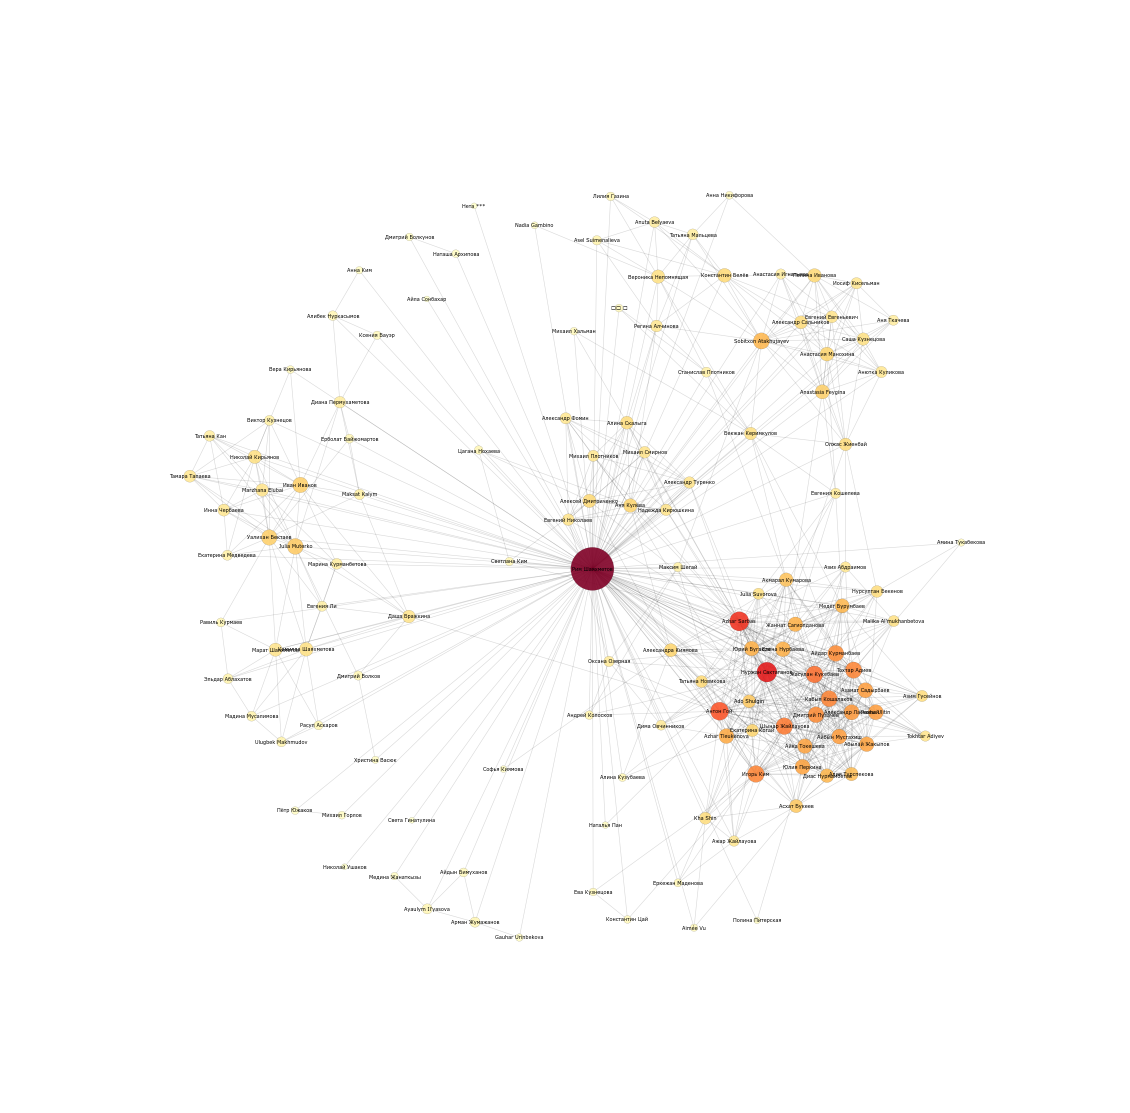

In [12]:
f = pl.figure(figsize=(15, 15))
nodes = graph.nodes()
degree_centrality = nx.degree_centrality(graph)
betweenness_centrality = nx.betweenness_centrality(graph)
eigenvector_centrality = nx.eigenvector_centrality(graph)
katz_centrality = nx.katz_centrality_numpy(graph)
closeness_centrality = nx.closeness_centrality(graph)
page_ranks = nx.pagerank(graph)

# pl.title('size ~ PAGE RANK centrality \n color ~ DEGREE centrality', fontsize=13)
node_size = [page_ranks[l]*10**4*2 for l in nodes]
node_color = [0.4 if l == my_uid else degree_centrality[l] for l in nodes]
nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='YlOrRd', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('graph.pdf')
# One of my friends has name '佳峰 謝' and matplotlib doesn't show his name properly

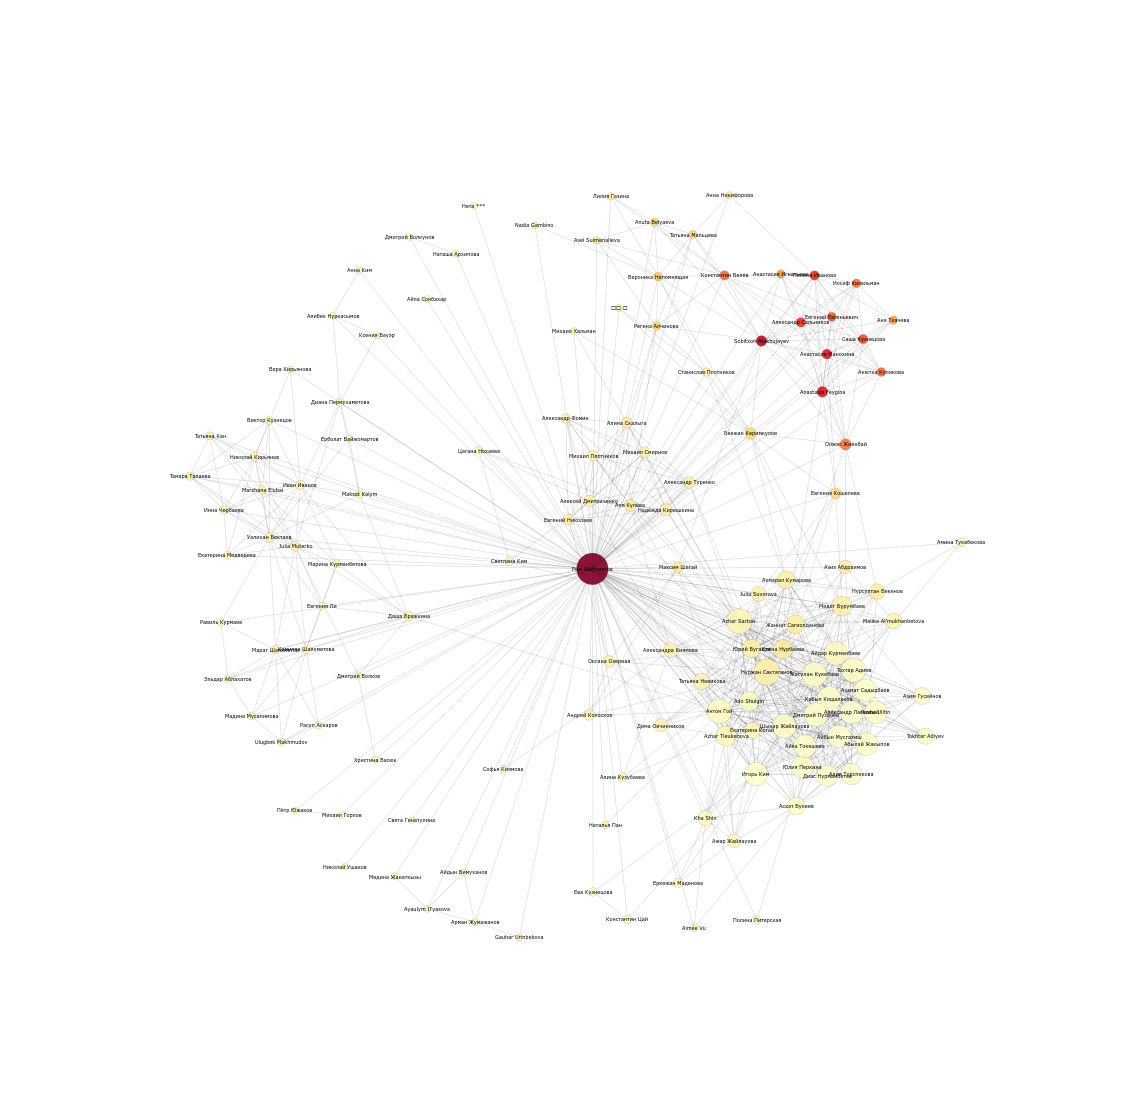

In [13]:
f = pl.figure(figsize=(15, 15))
# pl.title('size ~ EIGENVECTOR CENTRALITY, color ~ KATZ CENTRALITY')
node_size = [eigenvector_centrality[l]*10**3*3 for l in nodes]
node_color = [katz_centrality[l] for l in nodes]

nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='YlOrRd', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('graph_eigen_katz.pdf')

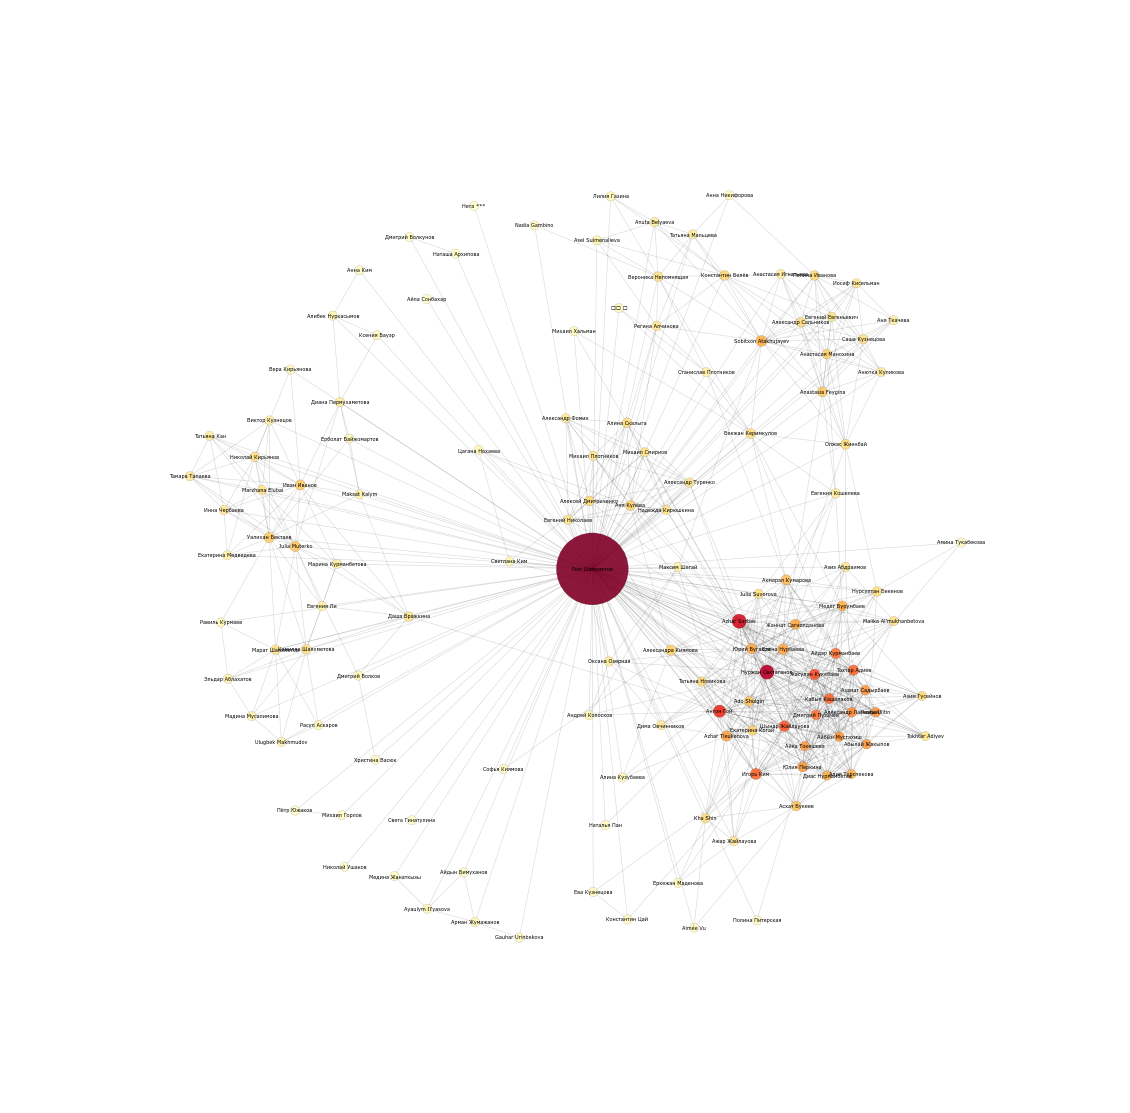

In [14]:
f = pl.figure(figsize=(15, 15))
# pl.title('size ~ BETWEENESS CENTRALITY, color ~ CLOSENESS CENTRALITY')
node_size = [np.log10(1.01 + betweenness_centrality[l])*10**4*2 for l in nodes]
node_color = [0.6 if l == my_uid else closeness_centrality[l] for l in nodes]
nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='YlOrRd', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('graph_closeness_betweeness.pdf')

In [15]:
print('average clustering coefficient =', nx.average_clustering(graph))
print('diameter =', nx.diameter(graph))
print('average shortest path length =', nx.average_shortest_path_length(graph))
print('transitivity coefficient =', nx.transitivity(graph))


average clustering coefficient = 0.7181817564520412
diameter = 2
average shortest path length = 1.9107457428068115
transitivity coefficient = 0.3805104408352668


In [16]:
print('assortativity by gender', nx.attribute_assortativity_coefficient(graph, 'gender'))
print('assortativity by city', nx.attribute_assortativity_coefficient(graph, 'city'))
print('assortativity by country', nx.attribute_assortativity_coefficient(graph, 'country'))
print('degree assortativity', nx.degree_assortativity_coefficient(graph))

assortativity by gender 0.01052809368314346
assortativity by city 0.03913596454796606
assortativity by country 0.054281167424358893
degree assortativity -0.174124312168


In [17]:
def degree_pdf(graph):
    degrees = pd.Series(list(graph.degree().values()))
    return (degrees.value_counts()/degrees.count()).sort_index()
    
def degree_cdf(graph):
    return degree_pdf(graph).cumsum()

def degree_ccdf(graph):
    return 1 - degree_cdf(graph)

In [18]:
def plot_pdf_cdf(graph):
    pl.figure(figsize=(15,5))
    pl.semilogx(degree_pdf(graph), 's--')
    pl.xlabel('degree')
    pl.ylabel('probability')
    pl.title('PDF')
    pl.savefig('pdf.pdf')
    pl.figure()
    degree_ccdf(graph).plot(style='-*', loglog=True, figsize=(15,5))
    pl.title('cCDF')
    pl.xlabel('degree')
    pl.ylabel('cCDF')
    pl.savefig('cCDF.pdf')

In [19]:
def estimate_alpha_sigma(observations, x_min=1):
    ''' MLE оценки alpha и sigma
    '''
    observations = np.asarray(observations)
    observations = observations[observations >= x_min]
    n = observations.shape[0]
    alpha = 1 + n/np.log(observations/x_min).sum()
    sigma = (alpha - 1)/np.sqrt(n)
    return alpha, sigma

In [20]:
def actual_cdf(observations, x_min=1):
    ''' Вычисляет настоящюю CDF (дискретная)
    '''
    observations = np.asarray(observations)
    observations = observations[observations >= x_min]
    x = pd.Series(observations).value_counts().sort_index()/observations.shape[0]
    return x.cumsum()

In [21]:
def hypothesis_cdf(observations, x_min=1, x_max=None):
    ''' для заданного X_min вычисляет оптимальное alpha и гипотетическую CDF
    '''
    observations = np.asarray(observations)
    observations = observations[observations >= x_min]
    alpha, sigma = estimate_alpha_sigma(observations, x_min=x_min)
    x = np.unique(observations)
    series = pd.Series(1 - (x/x_min)**(-alpha + 1), index=x)
    return series

In [22]:
def plot_data_hypothesis_diff(observations, x_min=1, x_max=None):
    ''' Рисует график разности настоящей и гипотетической CDF при заданном X_min
    '''
    observations = np.asarray(observations)
    observations = observations[observations >= x_min]
    if x_max is not None:
        observations = observations[observations <= x_max]
    pl.figure(figsize=(15,5))
    pl.title('CDF')
    pl.xlabel('degree')
    pl.ylabel('CDF')
    label = 'x_min=' + str(x_min)
    if x_max is not None:
        label += (', x_max=' + str(x_max))
    pl.semilogx(actual_cdf(observations), '--*', label='data from ' + label)
    pl.semilogx(hypothesis_cdf(observations, x_min=x_min), '-', 
                label='hypothesis with ' + label, linewidth=2)
    pl.legend()

In [23]:
def kolmogorov_smirnov_test(observations):
    pl.figure(figsize=(10, 5))
    x_mins = np.arange(1, observations.max())
    D = [np.max(np.abs(hypothesis_cdf(observations, x_min=x_min) - actual_cdf(observations, x_min=x_min))) for x_min in x_mins]
    pl.semilogx(x_mins, D, '-', color='red')
    pl.xlabel('x_min')
    pl.ylabel('D')
    pl.title('Kolmogorov-Smirnov test')
    minimun = x_mins[np.argmin(D)]
    print('MIN x_min =', minimun)
    pl.axvline(x_mins[np.argmin(D)], color='blue')
    return minimun

def plot_text(graph, observations, minimum, x_max=None):
    if x_max is not None:
        observations = observations[observations <= x_max]
    alpha, sigma = estimate_alpha_sigma(observations, x_min=minimum)
    print('alpha is', alpha)
    print('sigma is', '%.7f' % sigma)
    print('sigma**2 is', '%.7f' % sigma**2)
    if x_max is not None:
        print('Ending at x_max =', x_max-1, 'and', end=' ')
    print('Starting from x_min =', minimum, 
          'the degrees (x) are distributed by the Power Law with alpha ==', alpha)
    print('PDF(x) = (', (alpha-1), '/', minimum, ') *', '(x /', minimum, ') ^', -alpha)
    print('CDF(x) = 1 - (x /', minimum, ') ^', -alpha+1)

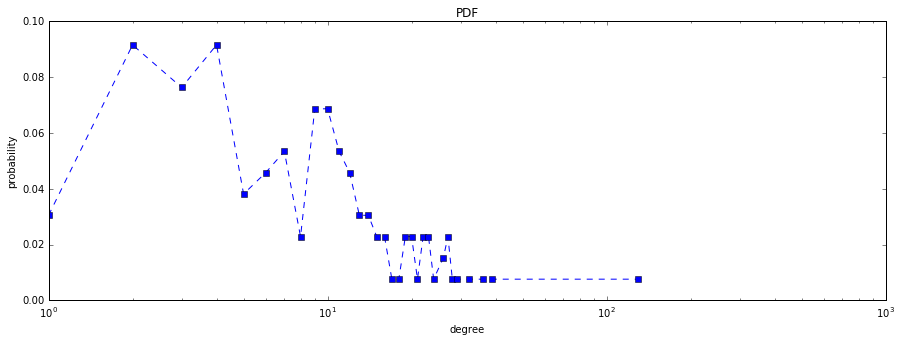

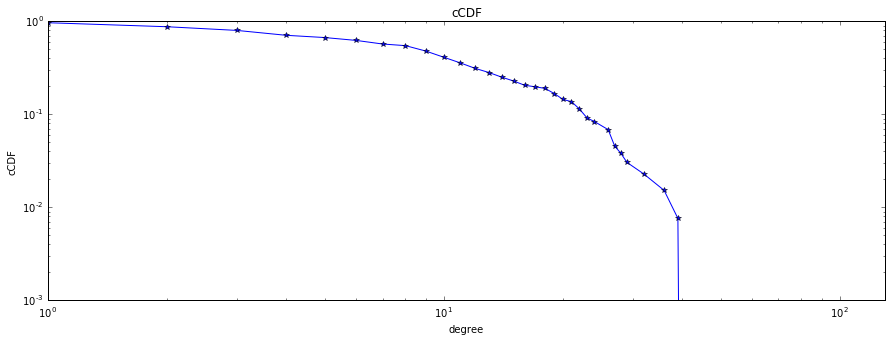

In [24]:
plot_pdf_cdf(graph)

### trying to fit Power Law, but it's not so good. Let's divide CDF on two regions, where different Power Law may take place

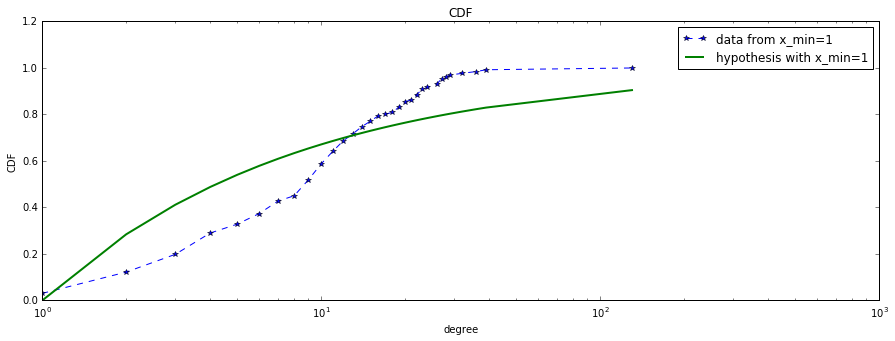

In [25]:
observations = np.asarray(list(graph.degree().values()))
plot_data_hypothesis_diff(observations)

MIN x_min = 8
LEFT SIDE OF THE DISTRIBUTION:

alpha is 1.79091797275
sigma is 0.1029687
sigma**2 is 0.0106026
Ending at x_max = 7 and Starting from x_min = 1 the degrees (x) are distributed by the Power Law with alpha == 1.79091797275
PDF(x) = ( 0.790917972753 / 1 ) * (x / 1 ) ^ -1.79091797275
CDF(x) = 1 - (x / 1 ) ^ -0.790917972753

RIGHT SIDE OF THE DISTRIBUTION:

alpha is 2.60047847233
sigma is 0.1848073
sigma**2 is 0.0341538
Starting from x_min = 8 the degrees (x) are distributed by the Power Law with alpha == 2.60047847233
PDF(x) = ( 1.60047847233 / 8 ) * (x / 8 ) ^ -2.60047847233
CDF(x) = 1 - (x / 8 ) ^ -1.60047847233


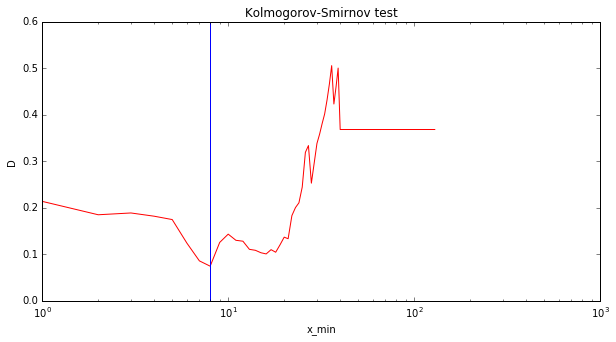

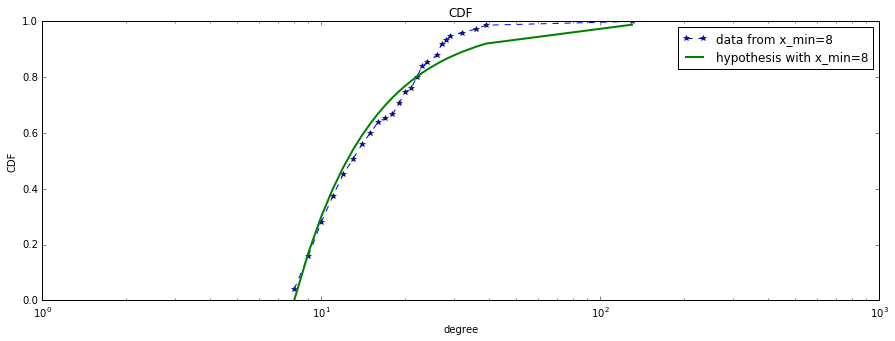

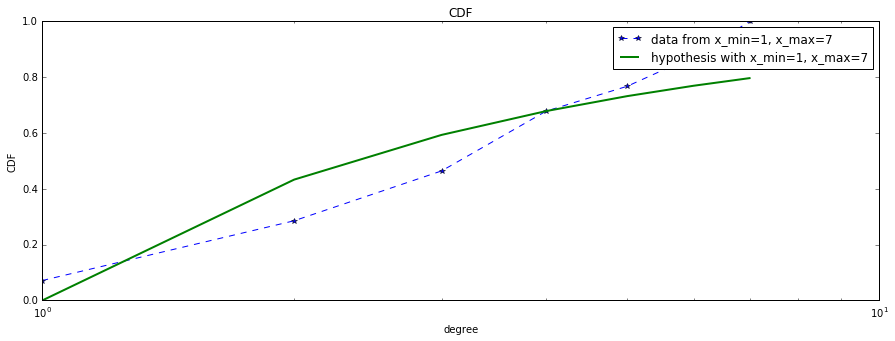

In [26]:
minimum = kolmogorov_smirnov_test(observations)
pl.savefig('kolmogorov.pdf')
plot_data_hypothesis_diff(observations, x_min=minimum)
pl.savefig('right.pdf')
plot_data_hypothesis_diff(observations, x_max=minimum-1)
pl.savefig('left.pdf')
print('LEFT SIDE OF THE DISTRIBUTION:', end='\n\n')
plot_text(graph, observations, minimum=1, x_max=minimum)
print('\nRIGHT SIDE OF THE DISTRIBUTION:', end='\n\n')
plot_text(graph, observations, minimum)
pl.savefig('cdf_split.pdf')

## That's not bad and the hypothesis, which states that CDF can be represented by two regions of different Power Law, seems reasonable

### Barbasi-Albert Random Graph model is not ideal, but according to the properties of the network is the closest

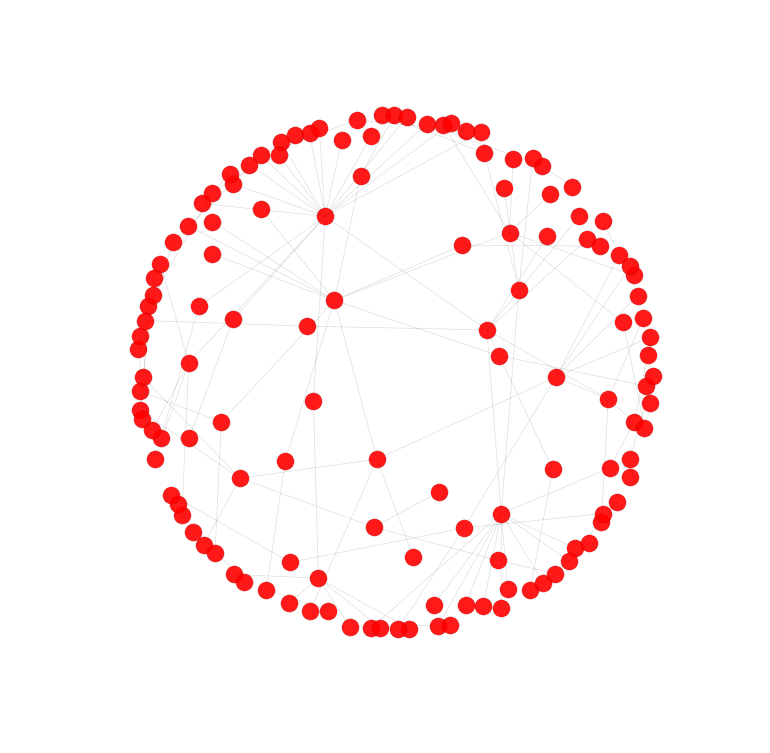

In [46]:
temp_graph = nx.barabasi_albert_graph(131, 1, seed=10023)

f = pl.figure(figsize=(10, 10))
temp_pos = nx.spring_layout(temp_graph, k=1.2/np.sqrt(131))
nx.draw(temp_graph, pos=temp_pos, font_color='black', 
        width=0, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(temp_graph, pos=temp_pos, alpha=edge_alpha, width=edge_width)

In [29]:
def cosine_similarity(graph):
    result = []
    nodes = graph.nodes()
    degrees = graph.degree()
    matrix = nx.adjacency_matrix(graph)
    for i in range(matrix.shape[0]):
        for j in range(i+1, matrix.shape[0]):
            result.append([nodes[i], nodes[j], (
                        matrix[i, :].multiply(matrix[j, :]).sum()/(np.sqrt(matrix[i, :].sum()*matrix[j].sum())))])
    return result

In [30]:
def get_similarities(similarities):
    names_df = pd.DataFrame(list(names.items()), columns=['uid', 'name'])
    similarities = pd.DataFrame(similarities,
                                columns=['user1', 'user2', 'sim'])
    
    similarities = similarities.merge(names_df, left_on='user1', right_on='uid')
    similarities['user1'] = similarities.name
    del similarities['uid'], similarities['name']
    
    similarities = similarities.merge(names_df, left_on='user2', right_on='uid')
    similarities['user2'] = similarities.name
    del similarities['uid'], similarities['name']
    
    return similarities.sort_values(by='sim', ascending=False)

In [31]:
def construct_sim_matrix(similarities):
    users_encoder = LabelEncoder()
    users_encoder.fit(nodes)
    sim_matrix = np.eye(users_encoder.classes_.shape[0])
    for u, v, s in similarities:
        i, j =  users_encoder.transform(u), users_encoder.transform(v)
        sim_matrix[i, j] = s
        sim_matrix[j, i] = s
    return sim_matrix
        

COSINE SIMILARITY


user1                user2       sim
2190     Николай Ушаков        Айла Сонбахар  1.000000
2344      Айла Сонбахар     Света Гинатулина  1.000000
2256     Николай Ушаков             Нета ***  1.000000
2345           Нета ***     Света Гинатулина  1.000000
2323     Николай Ушаков     Света Гинатулина  1.000000
2277      Айла Сонбахар             Нета ***  1.000000
7637  Надежда Кирюшкина     Михаил Плотников  0.948683
4425   Евгений Николаев    Александр Туренко  0.900000
132   Anastasia Feygina   Анастасия Манохина  0.897085
2766  Мадина Мусалимова        Расул Аскаров  0.894427
1215  Asel Suimenalieva         Лилия Газина  0.894427
402     Иосиф Кисельман      Анютка Куликова  0.888889
2799    Иосиф Кисельман  Анастасия Игнатьева  0.881917
2803    Анютка Куликова  Анастасия Игнатьева  0.881917
8367    Дмитрий Пузачев   Александр Ласковый  0.880705

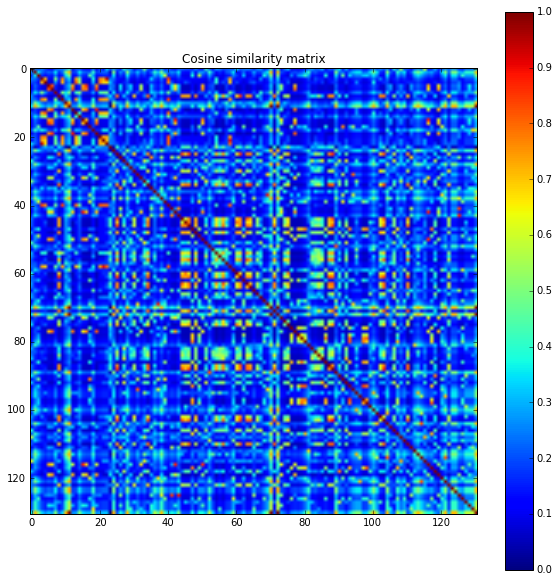

In [32]:
print('COSINE SIMILARITY')
similarities = cosine_similarity(graph)
pl.figure(figsize=(10, 10))
pl.title('Cosine similarity matrix')
pl.imshow(construct_sim_matrix(similarities))
pl.colorbar()
pl.savefig('cosine.pdf')
get_similarities(similarities).head(15)


JACCARD SIMILARITY


user1              user2       sim
474        Николай Ушаков           Нета ***  1.000000
5629             Нета ***      Айла Сонбахар  1.000000
5620       Николай Ушаков      Айла Сонбахар  1.000000
5730       Николай Ушаков   Света Гинатулина  1.000000
5739             Нета ***   Света Гинатулина  1.000000
5817        Айла Сонбахар   Света Гинатулина  1.000000
2040    Надежда Кирюшкина   Михаил Плотников  0.900000
4786    Александр Туренко   Евгений Николаев  0.818182
5527        Расул Аскаров  Мадина Мусалимова  0.800000
3124      Иосиф Кисельман    Анютка Куликова  0.800000
5982    Asel Suimenalieva       Лилия Газина  0.800000
2860  Анастасия Игнатьева    Иосиф Кисельман  0.777778
3085  Анастасия Игнатьева    Анютка Куликова  0.777778
2514  Анастасия Игнатьева        Аня Ткачева  0.750000
7572   Евгений Евгеньевич     Саша Кузнецова  0.750000

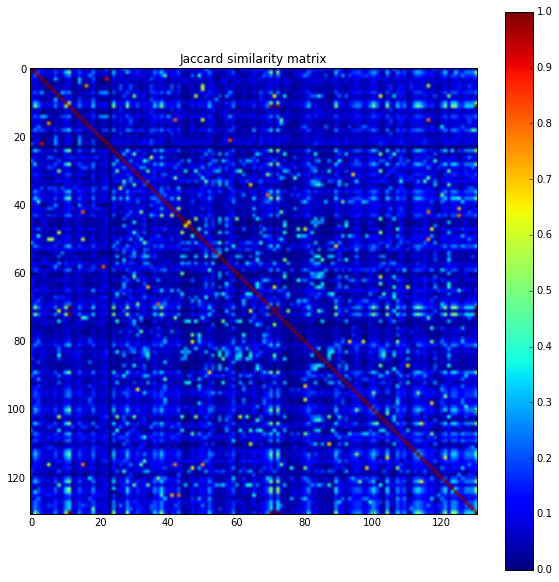

In [33]:
print('JACCARD SIMILARITY')
similarities = list(nx.jaccard_coefficient(graph))
pl.figure(figsize=(10, 10))
pl.title('Jaccard similarity matrix')
pl.imshow(construct_sim_matrix(similarities))
pl.colorbar()
pl.savefig('jaccard.pdf')
get_similarities(similarities).head(15)


Friends which have a few (only me) connections, have highest similarity between them. Also friends from one university/school or relatives tend to have high value of similarity.

Maximal Maximum cliques:
[12867893, 86579341, 56910820, 33644597, 31661689, 50059488, 40476645, 67725137, 132667107, 14805738, 182080254, 59911167, 69769139, 132600070]
[12867893, 86579341, 56910820, 33644597, 31661689, 50059488, 40476645, 67725137, 132667107, 14805738, 182080254, 59911167, 19017125, 215024368]
[12867893, 86579341, 56910820, 33644597, 31661689, 50059488, 40476645, 67725137, 132667107, 14805738, 182080254, 59911167, 19017125, 132600070]
[12867893, 86579341, 56910820, 33644597, 30821204, 50059488, 40476645, 67725137, 132667107, 14805738, 182080254, 59911167, 69769139, 132600070]
[12867893, 86579341, 56910820, 33644597, 30821204, 50059488, 40476645, 67725137, 132667107, 14805738, 182080254, 59911167, 19017125, 215024368]
[12867893, 86579341, 56910820, 33644597, 30821204, 50059488, 40476645, 67725137, 132667107, 14805738, 182080254, 59911167, 19017125, 132600070]
[12867893, 86579341, 56910820, 6275805, 50059488, 132667107, 40476645, 14805738, 67725137, 182080254, 59911167,

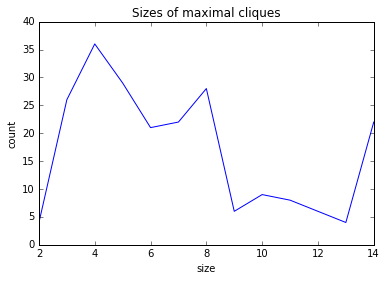

In [34]:
cliques = list(nx.find_cliques(graph))
sizes = pd.Series([len(l) for l in cliques])
pl.title('Sizes of maximal cliques')
pl.xlabel('size')
pl.ylabel('count')
sizes.value_counts().sort_index().plot()
pl.savefig('maximal_cliques_sizes.pdf')
print('Maximal Maximum cliques:')
for clique in cliques:
    if len(clique) == sizes.max():
        print(clique)

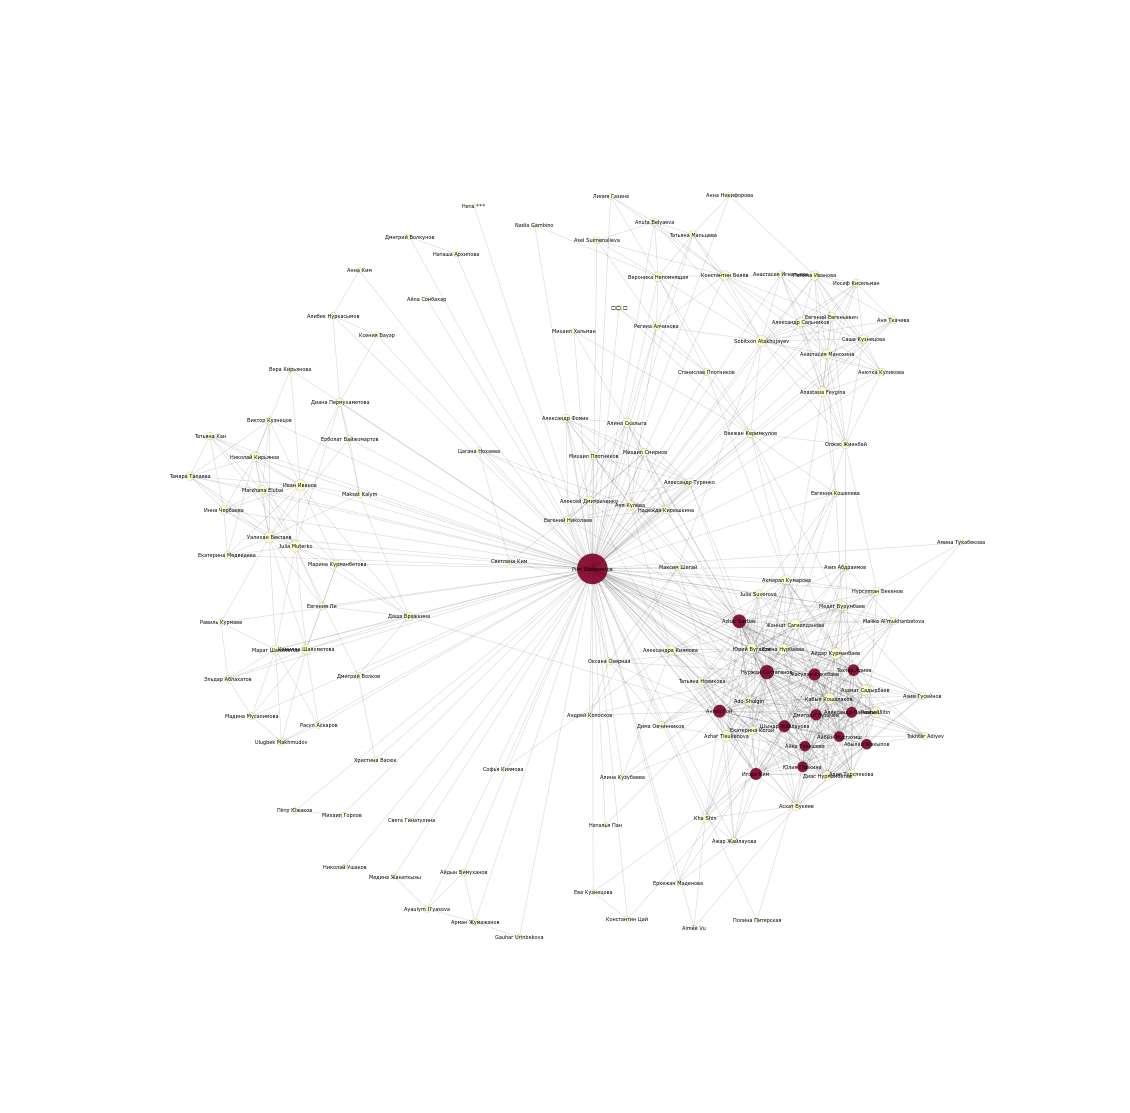

In [35]:
clique = cliques[sizes[sizes == sizes.max()].index[5]]
f = pl.figure(figsize=(15, 15))
# pl.title('Some Maximum Maximal Clique (colored). Node size ~ PageRank')
node_color = [1 if l in clique else 0 for l in nodes]
node_size = [page_ranks[l]*10**4 for l in nodes]

nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='YlOrRd', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('graph_clique.pdf')

In [36]:
nx.write_gml(graph, 'graph.gml')
G = ig.read('graph.gml')

In [37]:
dend_edge_betweenness = G.community_edge_betweenness(directed=False)
dend_fast_greedy = G.community_fastgreedy()
dend_walktrap = G.community_walktrap(steps=5)
dend_infomap = G.community_infomap(trials=50)
dend_label_propagation = G.community_label_propagation()
dend_leading_eigenvector = G.community_leading_eigenvector()
dend_spinglass = G.community_spinglass()

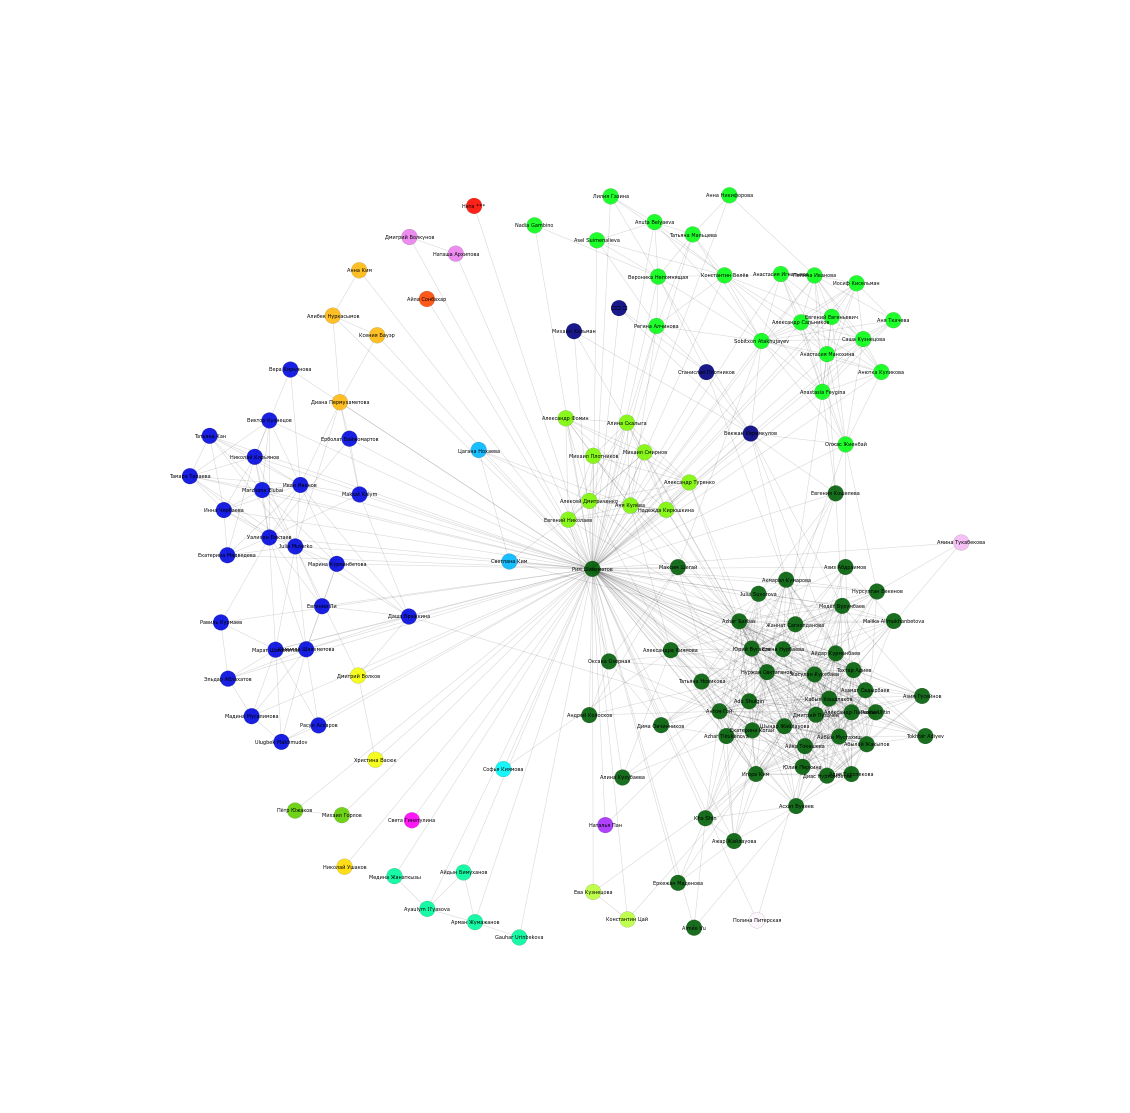

In [38]:
f = pl.figure(figsize=(15, 15))
# pl.title('COMMUNITIES by edge betweeness')
node_size = 250
nodes = G.vs.get_attribute_values('label')
membership = dend_edge_betweenness.as_clustering().membership
node_color = [c/max(membership) for c in membership]

nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='gist_ncar', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('edge_betweenness_com.pdf')

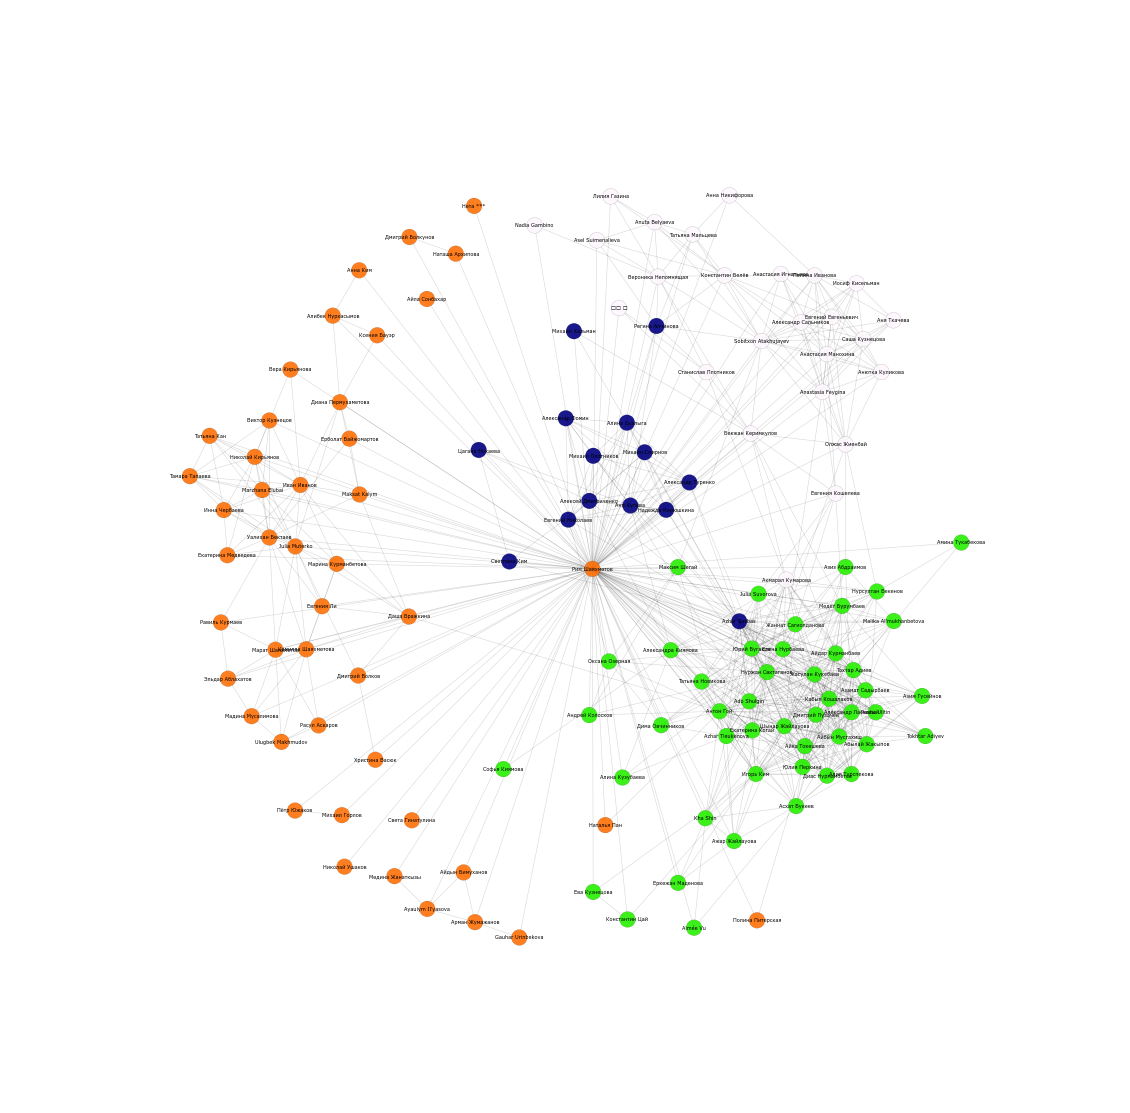

In [39]:
f = pl.figure(figsize=(15, 15))
# pl.title('COMMUNITIES by fast greedy')
node_size = 250
nodes = G.vs.get_attribute_values('label')
membership = dend_fast_greedy.as_clustering().membership
node_color = [c/max(membership) for c in membership]
nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='gist_ncar', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('fast_greedy_com.pdf')

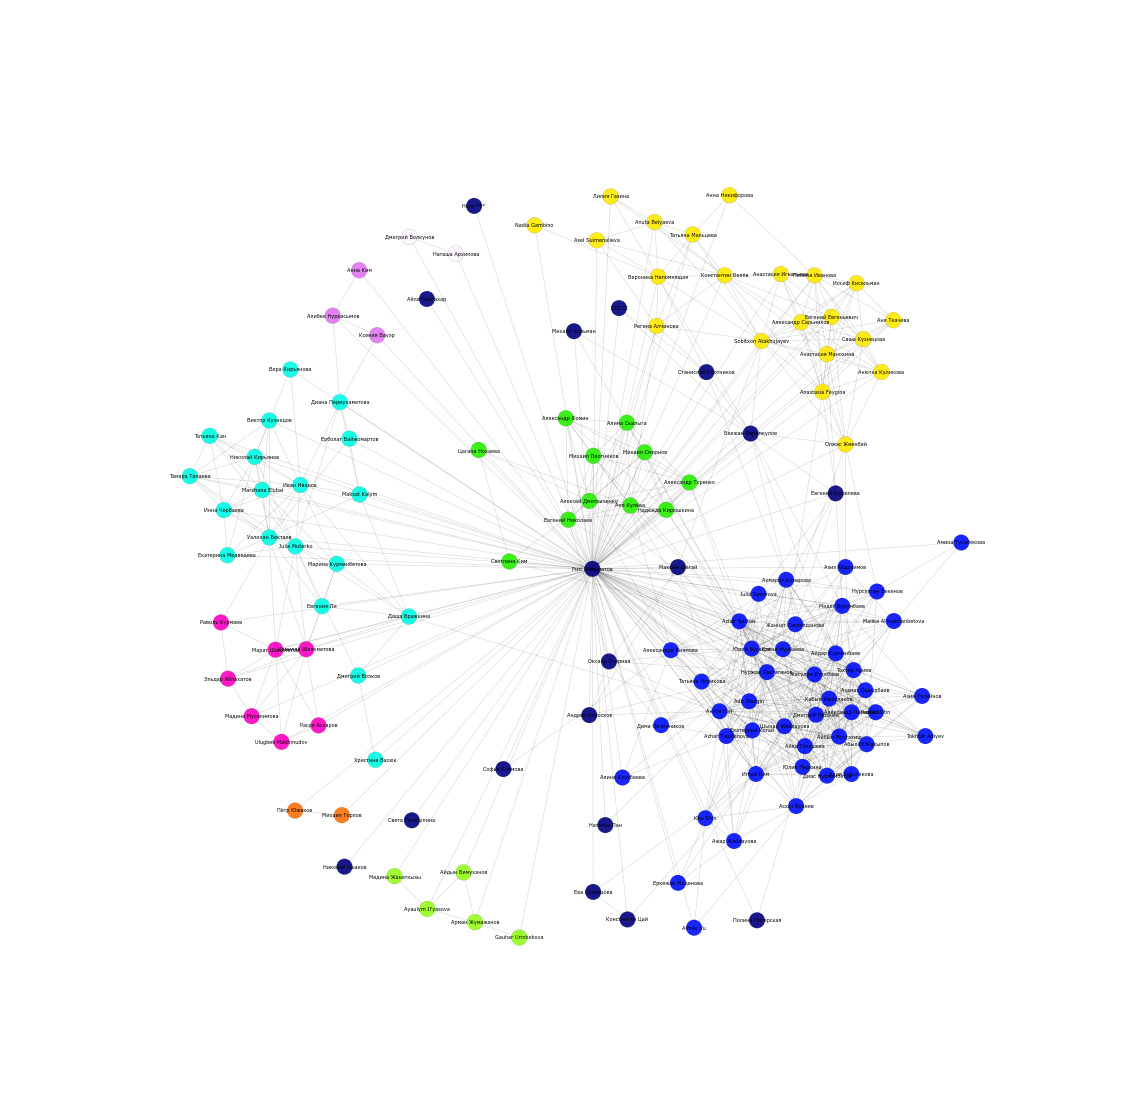

In [40]:
f = pl.figure(figsize=(15, 15))
# pl.title('COMMUNITIES by walktrap')
node_size = 250
nodes = G.vs.get_attribute_values('label')
membership = dend_walktrap.as_clustering().membership
node_color = [c/max(membership) for c in membership]
nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='gist_ncar', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('walktrap_com.pdf')

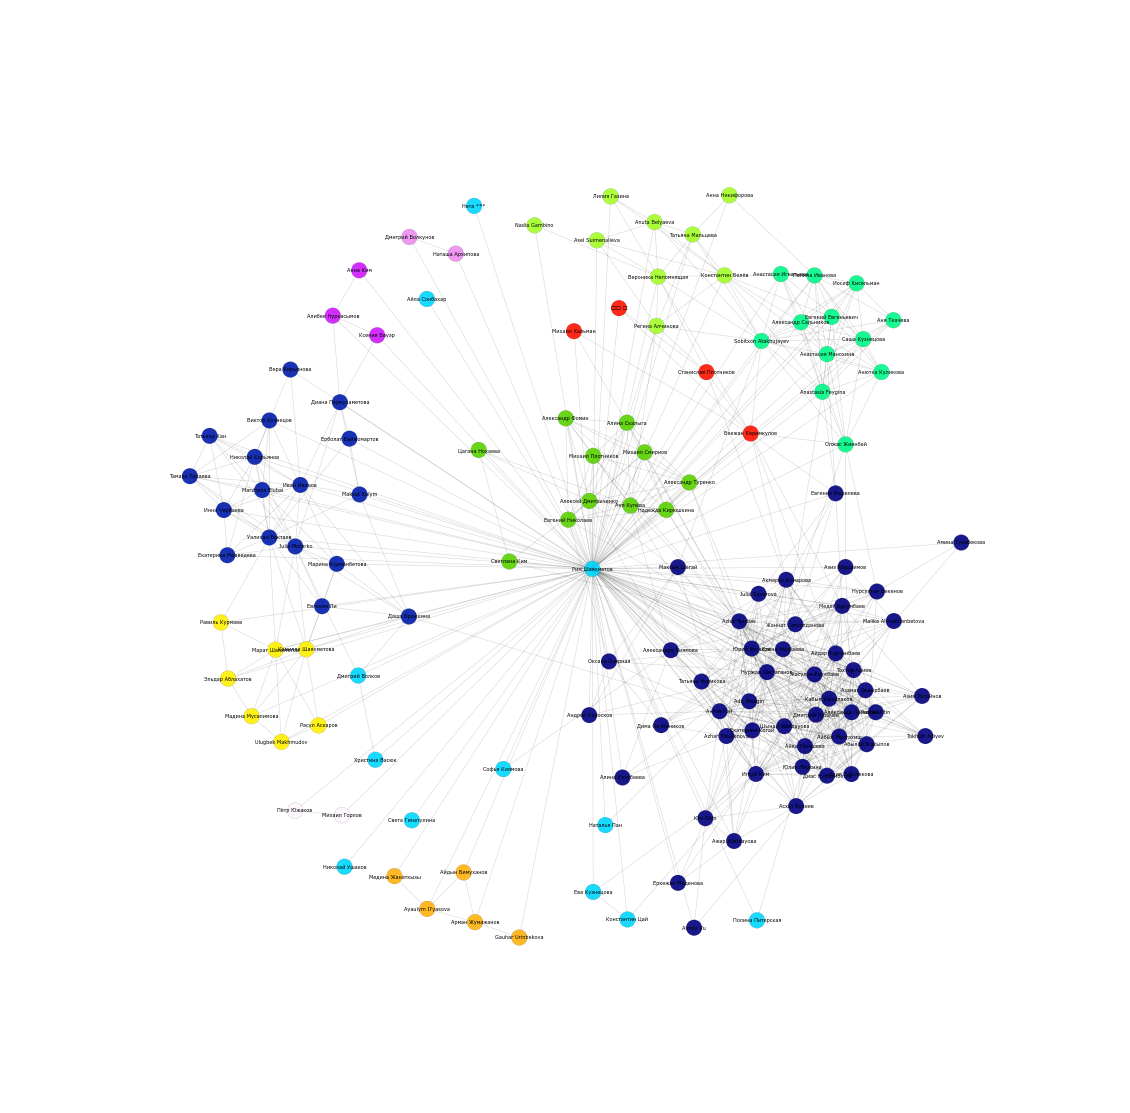

In [41]:
f = pl.figure(figsize=(15, 15))
# pl.title('COMMUNITIES by infomap')
node_size = 250
nodes = G.vs.get_attribute_values('label')
membership = [c[0] for c in dend_infomap.as_cover().membership]
node_color = [c/max(membership) for c in membership]
nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='gist_ncar', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('infomap_com.pdf')

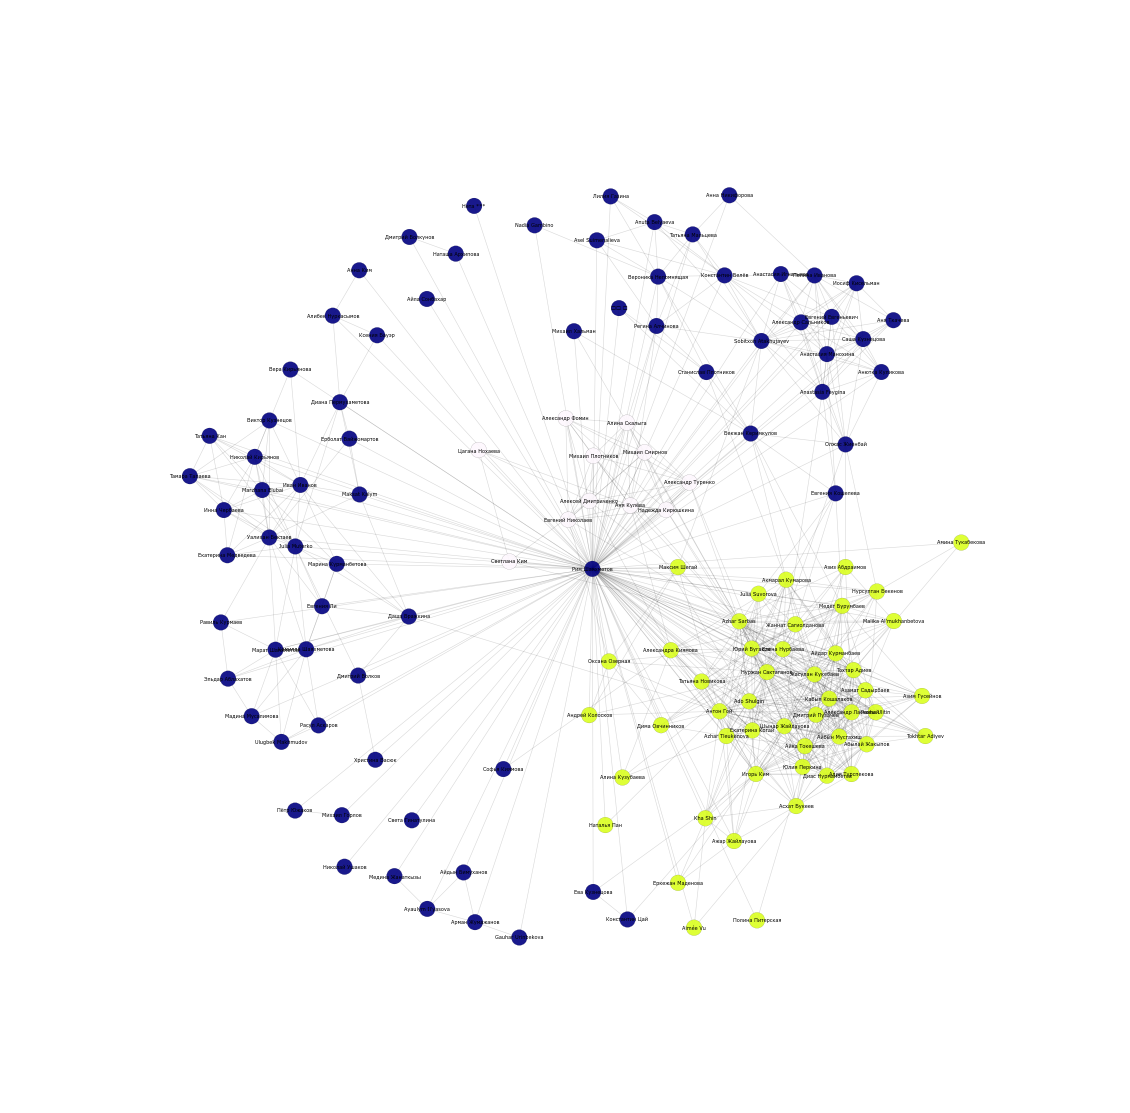

In [42]:
f = pl.figure(figsize=(15, 15))
# pl.title('COMMUNITIES by label propagation')
node_size = 250
nodes = G.vs.get_attribute_values('label')
membership = [c[0] for c in dend_label_propagation.as_cover().membership]
node_color = [c/max(membership) for c in membership]
nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='gist_ncar', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('label_propagation_com.pdf')

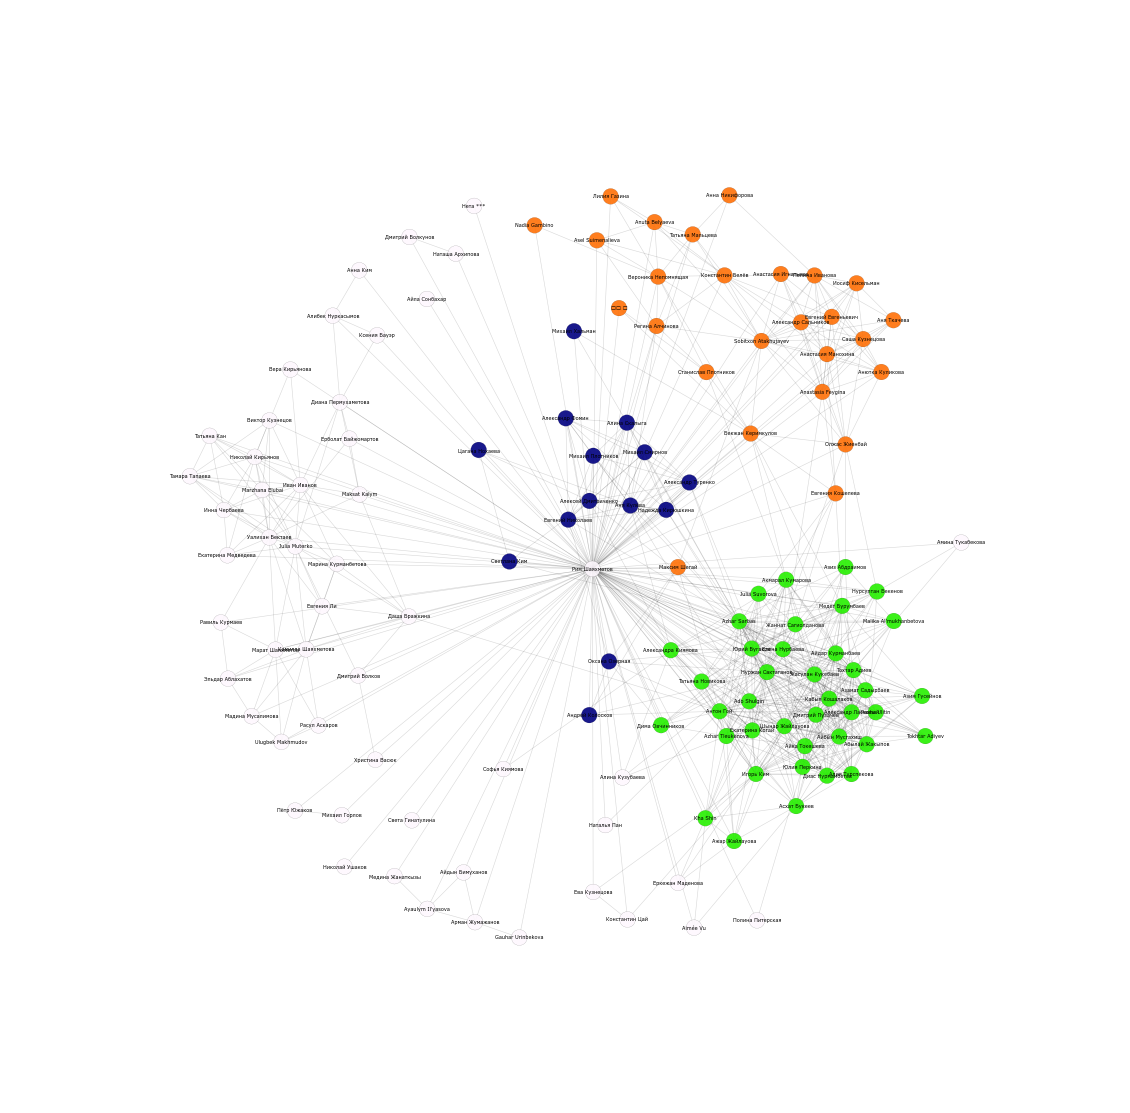

In [43]:
f = pl.figure(figsize=(15, 15))
# pl.title('COMMUNITIES by leading eigenvector')
node_size = 250
nodes = G.vs.get_attribute_values('label')
membership = [c[0] for c in dend_leading_eigenvector.as_cover().membership]
node_color = [c/max(membership) for c in membership]
nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='gist_ncar', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('leading_eigenvector_com.pdf')

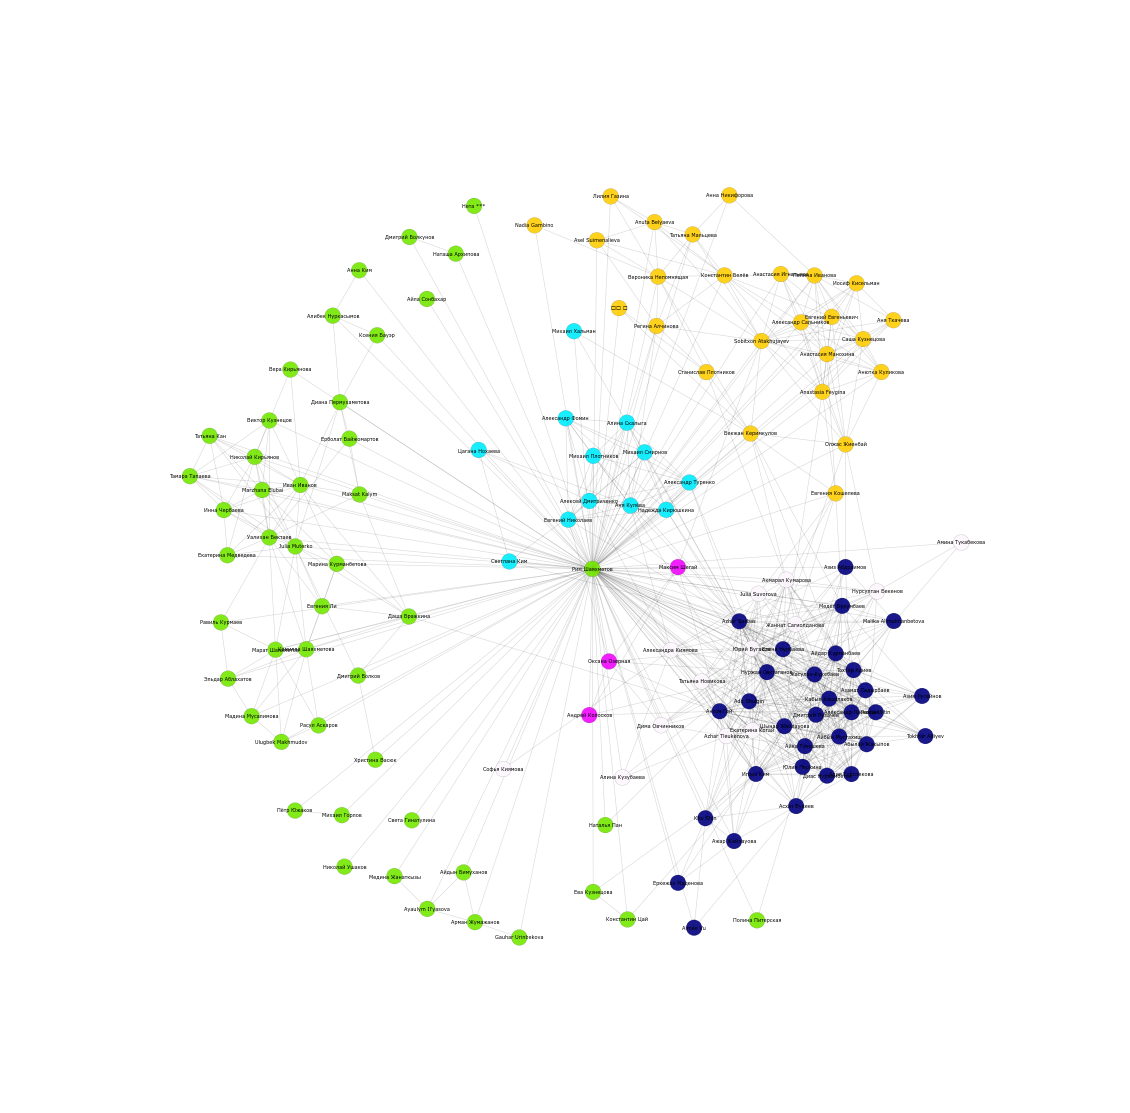

In [44]:
f = pl.figure(figsize=(15, 15))
# pl.title('COMMUNITIES by springlass')
node_size = 250
nodes = G.vs.get_attribute_values('label')
membership = [c[0] for c in dend_spinglass.as_cover().membership]
node_color = [c/max(membership) for c in membership]
nx.draw(graph, labels=names, pos=pos, font_family='Verdana', nodelist=nodes,
        cmap='gist_ncar', font_color='black', node_color=node_color, font_size=font_size, 
        width=0, node_size=node_size, alpha=node_alpha, linewidths=linewidths)
nx.draw_networkx_edges(graph, pos=pos, alpha=edge_alpha, width=edge_width)
pl.savefig('springlass_com.pdf')